<b>IMPORTANT</b>: Run the below cell to import the modules from previous challenge.

In [ ]:
%run solution1.ipynb

# **Coding Challenge Part 1: Debugging custom BERT code [7 points]**

BERT ([Bidirectional Encoder Representations from Transformers](https://arxiv.org/abs/1810.04805)) is a transformer based language model that is pretrained to generate contextualized embeddings. In this part, we provide a BERT implementation together with a pretrained checkpoint file. This BERT implementation includes 7 bugs in which some of these bugs break the code but some of them only impact the model performance.

Tasks:
* [**7 points**] Your goal is to get the code working. There are 7 bugs in the code, some of them lead to error in the code but some of them are designed to impair test accuracy but not break the code. You will get one point for each of the 7 bugs you find.

* [**1 points**] You will get extra points for also adding improved documentation to each of the functions we introduce in this section, and for describing the fixes to the bugs.


Note for usage and comparison:
*   In order to test this implementation, we provide ***bert_tiny.bin*** and example usage in the below cells.
*   You can check if your bugfixes are correct based on your results in "Coding challenge Part 2". Except the Bert imlementation, there is no bugs in other parts, so if your fixes are correct you should achieve the same results. We provide the expected results for you to compare.


**Please DO NOT use any additional library except the ones that are imported!!**

### **Identified bugs and explanations**

All the identified bugs are marked with comments in the code cell below. Here are their explanations:

**BUG 1**: Layer normalization is designed to normalize the features (i.e., the `hidden_size` dimension) for each individual token in the sequence across the batch to zero mean and unit variance. This is different from batch normalization, which normalizes across the batch dimension.
1. Therefore, the mean should be calculated for each example/row (dim=-1) instead batch/column (dim=0).
2. The mean should be subtracted from the input to get zero mean. Hence, it should be (x-u) instead of (x+u).

Layer normalization is crucial in enabling training of deep neural networks as they help centering the input to activation functions and improving optimization algorithms like gradient descent.

**BUG 2**: Tensors in PyTorch can be stored in memory in a non-contiguous manner, especially after certain operations like transpose, permute, or slicing. The `.contiguous()` method returns a contiguous tensor containing the same data. This helps improve performance and memory efficiency. If we try to use `.view()` on a non-contiguous tensor, PyTorch will raise an error.

**BUG 3**: `torch.matmul(q, k)` returns an error as the dimensions for matrix multiplication don't align. This should be `k.transpose(-1, -2)`. Therefore, the resultant matrix multiplication would be `(batch, num_heads, seq_len, attention_head_size) x (batch, num_heads, attention_head_size, seq_len) = (batch, num_heads, seq_len, seq_len)`.

**BUG 4**: The attention mask tells the model what part of the inputs to attend to. When mask is 0, setting values to `-inf` (before applying a softmax function) effectively masks those values out, making their softmax result very close to zero. When mask is 1, we just copy the attention scores in those positions. If we set values to `inf` instead of `-inf` then we would get `nan` values in the output embeddings.

**BUG 5**: We need to convert raw attention scores (`s`) to probabilities (`p`) using softmax. This helps the model learn distribute its attention to different parts of the input sequence when we multiply these probabilities with the `values` matrix. Therefore, `p = F.softmax(s, dim=-1)`.

**BUG 6**: Like layer normalization, residual connections are another important component to stabilize training of deep neural networks. Transformers utilize this technique for its multi-head attention block and the feed forward block.

**BUG 7**: The Transformer architecture doesn't have any inherent notion of the order and type of tokens. To address this, positional and type encodings are added to the embeddings. The Transformer architecture adds these embeddings instead of concatenating them to keep the dimensions of the input same, reducing the complexity of learning when combining the two information, and avoiding increase in computational costs.

In [10]:
def gelu(x):
    """Implementation of the gelu activation function.

    Returns:
        torch.Tensor: Output tensor of shape [batch_size, seq_len, hidden_size] containing the output of the gelu activation function.
    """
    return x * 0.5 * (1.0 + torch.erf(x / math.sqrt(2.0)))


class Config(object):
    """Configuration class to store the configuration of a `BertModel`."""
    def __init__(self,
                vocab_size,
                hidden_size=768,
                num_hidden_layers=12,
                num_attention_heads=12,
                intermediate_size=3072,
                # Dropout of 0.9 was too high, changing it to 0.1
                dropout_prob=0.1,
                max_position_embeddings=512,
                type_vocab_size=2,
                initializer_range=0.02):
        """Constructs Config for BertModel.

        Args:
            vocab_size (int): Vocabulary size of `inputs_ids` in `BertModel`.
            hidden_size (int, optional): Size of the encoder layers and the pooler layer. Defaults to 768.
            num_hidden_layers (int, optional): Number of hidden layers in the Transformer encoder. Defaults to 12.
            num_attention_heads (int, optional): Number of attention heads for each attention layer in the Transformer encoder. Defaults to 12.
            intermediate_size (int, optional): The size of the "intermediate" (i.e., feed-forward) layer in the Transformer encoder. Defaults to 3072.
            dropout_prob (float, optional): The dropout probability for all fully connected layers in the embeddings, encoder, and pooler. Defaults to 0.1.
            max_position_embeddings (int, optional): The maximum sequence length that this model might ever be used with. Defaults to 512.
            type_vocab_size (int, optional): The vocabulary size of the `token_type_ids` passed into `BertModel`. Defaults to 2.
            initializer_range (float, optional): The standard deviation of the truncated_normal_initializer for initializing all weight matrices. Defaults to 0.02.
        """

        self.vocab_size = vocab_size
        self.hidden_size = hidden_size
        self.num_hidden_layers = num_hidden_layers
        self.num_attention_heads = num_attention_heads
        self.intermediate_size = intermediate_size
        self.hidden_dropout_prob = dropout_prob
        self.attention_probs_dropout_prob = dropout_prob
        self.max_position_embeddings = max_position_embeddings
        self.type_vocab_size = type_vocab_size
        self.initializer_range = initializer_range

    @classmethod
    def from_dict(cls, dict_object):
        """Constructs Config from a Python dictionary of parameters.

        Args:
            dict_object (dict): Dictionary containing the configuration parameters.

        Returns:
            Config: Configuration object constructed from the dictionary.
        """
        config = Config(vocab_size=None)
        for (key, value) in dict_object.items():
            config.__dict__[key] = value
        return config


class LayerNorm(nn.Module):
      """Layer normalization module."""
      def __init__(self, hidden_size, variance_epsilon=1e-12):
        """Constructs LayerNorm object for Transformer layer in BERT model.

        Args:
            hidden_size (int): Size of hidden dimension.
            variance_epsilon (float, optional): A value added to the denominator for numerical stability. Defaults to 1e-12.
        """
        super(LayerNorm, self).__init__()
        self.gamma = nn.Parameter(torch.ones(hidden_size))
        self.beta = nn.Parameter(torch.zeros(hidden_size))
        self.variance_epsilon = variance_epsilon

      def forward(self, x):
        """Forward pass of the LayerNorm layer.

        Args:
            x (torch.Tensor): Input tensor of shape [batch_size, hidden_size]

        Returns:
            torch.Tensor: Normalized input tensor.
        """
        # BUG 1: We need to find mean of individual examples in each batch
        # instead of calculating mean of the examples across batch
        u = x.mean(-1, keepdim=True)
        # BUG 1: Mean should be subtracted from the input
        s = (x - u).pow(2).mean(-1, keepdim=True)
        x = (x - u) / torch.sqrt(s + self.variance_epsilon)
        return self.gamma * x + self.beta


class MLP(nn.Module):
      """Feed forward network with gelu activation"""
      def __init__(self, hidden_size, intermediate_size):
        """Constructs MLP object for Transformer layer in BERT model.

        Args:
            hidden_size (int): Size of hidden dimension.
            intermediate_size (int): Size of intermediate dimension.
        """
        super(MLP, self).__init__()
        self.dense_expansion = nn.Linear(hidden_size, intermediate_size)
        self.dense_contraction = nn.Linear(intermediate_size, hidden_size)

      def forward(self, x):
        """Forward pass of the MLP layer.

        Args:
            x (torch.Tensor): Input tensor of shape [batch_size, seq_len, hidden_size] containing the input features.

        Returns:
            torch.Tensor: Output tensor of shape [batch_size, seq_len, hidden_size] containing the output features.
        """
        x = self.dense_expansion(x)
        x = self.dense_contraction(gelu(x))
        return x


class Layer(nn.Module):
    """The Transformer layer"""
    def __init__(self, config):
        """Constructs Layer object for Transformer layer in BERT model based on config.

        Args:
            config (Config): Configuration of the BERT model containing the hyperparameters.
        """
        super(Layer, self).__init__()

        self.hidden_size = config.hidden_size
        self.num_attention_heads = config.num_attention_heads
        self.attention_head_size = int(config.hidden_size / config.num_attention_heads)
        self.all_head_size = self.num_attention_heads * self.attention_head_size

        self.query = nn.Linear(config.hidden_size, self.all_head_size)
        self.key = nn.Linear(config.hidden_size, self.all_head_size)
        self.value = nn.Linear(config.hidden_size, self.all_head_size)

        self.dropout = nn.Dropout(config.attention_probs_dropout_prob)

        self.attn_out = nn.Linear(config.hidden_size, config.hidden_size)
        self.ln1 = LayerNorm(config.hidden_size)

        self.mlp = MLP(config.hidden_size, config.intermediate_size)
        self.ln2 = LayerNorm(config.hidden_size)

    def split_heads(self, tensor, num_heads, attention_head_size):
        """Split hidden_size into num_heads * attention_head_size and transpose into shape [batch, num_heads, seq_len, attention_head_size]

        Args:
            tensor (torch.Tensor): Input tensor of shape [batch_size, seq_len, hidden_size]
            num_heads (int): Number of attention heads.
            attention_head_size (int): Size of each attention head.

        Returns:
            torch.Tensor: Tensor of shape [batch_size, num_heads, seq_len, attention_head_size] containing the split heads.
        """
        new_shape = tensor.size()[:-1] + (num_heads, attention_head_size)
        tensor = tensor.view(*new_shape) # batch, seq_len, num_heads, attention_head_size
        # BUG 2: Call .contiguous() after .permute()
        return tensor.permute(0, 2, 1, 3).contiguous() # batch, num_heads, seq_len, attention_head_size

    def merge_heads(self, tensor, num_heads, attention_head_size):
        """Transpose and then reshape into shape [batch, seq_len, hidden_size]

        Args:
            tensor (torch.Tensor): Input tensor of shape [batch_size, num_heads, seq_len, attention_head_size] containing the split heads.
            num_heads (int): Number of attention heads.
            attention_head_size (int): Size of each attention head in the input tensor.

        Returns:
            torch.Tensor: Tensor of shape [batch_size, seq_len, hidden_size] containing the merged heads.
        """
        # tensor.shape: batch, num_heads, seq_len, attention_head_size
        tensor = tensor.permute(0, 2, 1, 3).contiguous() # batch, seq_len, num_heads, attention_head_size
        new_shape = tensor.size()[:-2] + (num_heads * attention_head_size,)
        return tensor.view(new_shape) # batch, seq_len, all_head_size

    def attn(self, q, k, v, attention_mask):
        """Attention mechanism for the Transformer layer.

        Args:
            q (torch.Tensor): Query tensor of shape [batch_size, num_heads, seq_len, attention_head_size] containing the query vectors for all attention heads.
            k (torch.Tensor): Key tensor of shape [batch_size, num_heads, seq_len, attention_head_size] containing the key vectors for all attention heads.
            v (torch.Tensor): Value tensor of shape [batch_size, num_heads, seq_len, attention_head_size] containing the value vectors for all attention heads.
            attention_mask (torch.Tensor): Mask to avoid performing attention on padding token indices of shape [batch_size, seq_len].

        Returns:
            torch.Tensor: Tensor of shape [batch_size, num_heads, seq_len, attention_head_size] containing the attention outputs for all attention heads.
        """
        mask = attention_mask == 1
        mask = mask.unsqueeze(1).unsqueeze(2)

        # BUG 3: k should be k.transpose(-1, -2)
        s = torch.matmul(q, k.transpose(-1, -2)) # batch, num_heads, seq_len, seq_len
        s = s / math.sqrt(self.attention_head_size)

        # BUG 4: Replace attention scores with -inf based on mask
        s = torch.where(mask, s, torch.tensor(float('-inf')))

        # BUG 5: Convert attention scores to probabilities using softmax
        p = F.softmax(s, dim=-1) # batch, num_heads, seq_len, seq_len
        p = self.dropout(p)

        a = torch.matmul(p, v) # batch, num_heads, seq_len, attention_head_size
        return a

    def forward(self, x, attention_mask):
        """Forward pass of the Transformer layer in BERT.

        Args:
            x (torch.Tensor): Input tensor of shape [batch_size, seq_len, hidden_size]
            attention_mask (torch.Tensor): Mask to avoid performing attention on padding token indices of shape [batch_size, seq_len].

        Returns:
            torch.Tensor: Output tensor of shape [batch_size, seq_len, hidden_size] containing the output of the Transformer layer.
        """
        q, k, v = self.query(x), self.key(x), self.value(x) # batch, seq_len, all_head_size

        q = self.split_heads(q, self.num_attention_heads, self.attention_head_size) # batch, num_heads, seq_len, attention_head_size
        k = self.split_heads(k, self.num_attention_heads, self.attention_head_size)
        v = self.split_heads(v, self.num_attention_heads, self.attention_head_size)

        a = self.attn(q, k, v, attention_mask) # batch, num_heads, seq_len, attention_head_size
        a = self.merge_heads(a, self.num_attention_heads, self.attention_head_size) # batch, seq_len, all_head_size
        a = self.attn_out(a) # batch, seq_len, hidden_size (because: hidden_size == all_head_size)
        a = self.dropout(a)
        # BUG 6: Missing residual connection
        a = self.ln1(a + x)

        m = self.mlp(a) # batch, seq_len, hidden_size
        m = self.dropout(m)
        # BUG 6: Missing residual connection
        m = self.ln2(m + a)

        return m


class Bert(nn.Module):
      """Custom BERT implementation"""
      def __init__(self, config_dict):
        """Constructs Bert model based on config_dict.

        Args:
            config_dict (dict): Dictionary containing the configuration of the model.
        """
        super(Bert, self).__init__()
        self.config = Config.from_dict(config_dict)
        self.embeddings = nn.ModuleDict({
          'token': nn.Embedding(self.config.vocab_size, self.config.hidden_size, padding_idx=0),
          'position': nn.Embedding(self.config.max_position_embeddings, self.config.hidden_size),
          'token_type': nn.Embedding(self.config.type_vocab_size, self.config.hidden_size),
        })

        self.ln = LayerNorm(self.config.hidden_size)
        self.dropout = nn.Dropout(self.config.hidden_dropout_prob)

        self.layers = nn.ModuleList([
            Layer(self.config) for _ in range(self.config.num_hidden_layers)
        ])

        self.pooler = nn.Sequential(OrderedDict([
            ('dense', nn.Linear(self.config.hidden_size, self.config.hidden_size)),
            ('activation', nn.Tanh()),
        ]))

      def forward(self, input_ids, attention_mask=None, token_type_ids=None, ):
        """Forward pass of the model to generate embeddings.

        Args:
            input_ids (torch.Tensor): Input tensor of shape [batch_size, seq_len] containing token ids of tokens in the input sequence.
            attention_mask (torch.Tensor, optional): Mask to avoid performing attention on padding token indices. Defaults to None.
            token_type_ids (torch.Tensor, optional): Segment token indices to indicate first and second portions of the inputs. Defaults to None.

        Returns:
            Tuple[torch.Tensor, torch.Tensor]: Tuple of output embeddings of shape [batch_size, seq_len, hidden_size] and pooled output of shape [batch_size, hidden_size].
        """
        position_ids = torch.arange(input_ids.size(1), dtype=torch.long, device=input_ids.device)
        position_ids = position_ids.unsqueeze(0).expand_as(input_ids)
        if attention_mask is None:
            attention_mask = torch.ones_like(input_ids)
        if token_type_ids is None:
            token_type_ids = torch.zeros_like(input_ids)

        # BUG 7: Embeddings should be summed together, not concatenated
        x = (self.embeddings.token(input_ids) +
              self.embeddings.position(position_ids) +
              self.embeddings.token_type(token_type_ids))
        x = self.dropout(self.ln(x))

        for layer in self.layers:
            x = layer(x, attention_mask)

        o = self.pooler(x[:, 0])
        return (x, o)

      def load_model(self, path):
        """Load model from path and return the model.

        Args:
            path (str): Path to the model checkpoint.

        Returns:
            Bert: Bert model loaded from the checkpoint.
        """
        self.load_state_dict(torch.load(path))
        return self

**Download weights for the custom Bert**

In [11]:
!wget https://github.com/for-ai/bert/raw/master/bert_tiny.bin

--2023-10-01 04:13:46--  https://github.com/for-ai/bert/raw/master/bert_tiny.bin
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/for-ai/bert/master/bert_tiny.bin [following]
--2023-10-01 04:13:47--  https://raw.githubusercontent.com/for-ai/bert/master/bert_tiny.bin
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17555010 (17M) [application/octet-stream]
Saving to: ‘bert_tiny.bin’

bert_tiny.bin       100%[===================>]  16.74M  --.-KB/s    in 0.04s   

2023-10-01 04:13:47 (383 MB/s) - ‘bert_tiny.bin’ saved [17555010/17555010]



**An example use of pretrained BERT with transformers library to encode a sentence**

In [5]:
MODEL_NAME = 'prajjwal1/bert-tiny'
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

bert_config = {"hidden_size": 128, "num_attention_heads": 2, "num_hidden_layers": 2, "intermediate_size": 512, "vocab_size": 30522}
bert = Bert(bert_config).load_model('bert_tiny.bin')

#EXAMPLE USE
sentence = 'An example use of pretrained BERT with transformers library to encode a sentence'
tokenized_sample = tokenizer(sentence, return_tensors='pt', padding='max_length', max_length=512)
output = bert(input_ids=tokenized_sample['input_ids'],
              attention_mask=tokenized_sample['attention_mask'],)

# We use "pooler_output" for simplicity. This corresponds the last layer
# hidden-state of the first token of the sequence (CLS token) after
# further processing through the layers used for the auxiliary pretraining task.
embedding = output[1]
print(f'\nResulting embedding shape: {embedding.shape}')


Resulting embedding shape: torch.Size([1, 128])


# **Coding Challenge Part 2: Evaluate a pretrained BERT model on STS benchmark [4 points]**

**Please do not use additional library except the ones that are imported!!**

In this part, we are going to evaluate a pretrained BERT model on STS benchmark without applying any additional training. For the evaluation we provide Pearson/Spearman correlation functions and cosine similarity method.

Tasks:

*   **[2 Points]** Prepare an evaluation data loader and evaluation loop: Read in the STS data, tokenize it as shown in the example,  generate the dataloader and return Pearson and Spearman correlation scores.
*   **[1 Point]** Implement cosine similarity function, explained as TODO

**[1 Point] Question**: What is the difference between Pearson and Spearman correlation, and why you might want to evaluate using both metrics?

**Answer**:



| Criteria                  | Pearson Correlation                          | Spearman Correlation                         |
|---------------------------|----------------------------------------------|----------------------------------------------|
| **Type of Relationship**  | Linear                                       | Monotonic                                    |
| **Sensitivity to Outliers**| High                                         | Low                                          |
| **Distribution Assumptions**| Assumes normal distribution                  | No distributional assumptions                |
| **Scale of Measurement**  | Interval/Ratio                               | Ordinal, Interval/Ratio                      |
| **Mathematical Complexity**| Involves covariance and standard deviation  | Based on ranks                               |
| **Robustness**            | Less Robust                                  | More Robust                                  |
| **Focus**                 | Absolute magnitudes                          | Relative ordering                            |
| **Interpretability**      | Quantifies linear relationship strength      | Quantifies monotonic relationship strength   |
| **Use Case in STS**       | Checks linear alignment with ground truth    | Checks monotonic alignment with ground truth |
| **Diagnostic Utility**    | Sensitive to anomalies in dataset            | Robust to anomalies in dataset               |

**Why Use Both?**

1. **Comprehensiveness**: Using both Pearson and Spearman provides a more comprehensive evaluation of the BERT model.

2. **Nature of Relationship**: If both Pearson and Spearman are high, the relationship might be linear. If Spearman is high but Pearson is low, the relationship might be monotonic but not linear.

3. **Outlier Diagnosis**: A significant difference between Pearson and Spearman could indicate the presence of outliers.

4. **Assumptions**: These metrics can help validate or invalidate any assumptions about the linearity or monotonicity of the relationship.

**Semantic Textual Similarity (STS) benchmark:**
STS dataset consists of a set of sentence pairs with a semantic similarity scores for each pair. We want to use this dataset to evaluate the quality of a sentence encoder.

Dataset includes:

*   Sentence pair: (sentence1, sentence2)
*   Similarity score: ranging 1 to 5 where 5 corresponds highest similarity
*   Splits: train, dev, test

**Download datasets**

In [12]:
!wget https://sbert.net/datasets/stsbenchmark.tsv.gz

--2023-10-01 04:13:53--  https://sbert.net/datasets/stsbenchmark.tsv.gz
Resolving sbert.net (sbert.net)... 104.21.67.200, 172.67.180.145, 2606:4700:3036::6815:43c8, ...
Connecting to sbert.net (sbert.net)|104.21.67.200|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://public.ukp.informatik.tu-darmstadt.de/reimers/sentence-transformers/datasets/stsbenchmark.tsv.gz [following]
--2023-10-01 04:13:54--  https://public.ukp.informatik.tu-darmstadt.de/reimers/sentence-transformers/datasets/stsbenchmark.tsv.gz
Resolving public.ukp.informatik.tu-darmstadt.de (public.ukp.informatik.tu-darmstadt.de)... 130.83.167.186
Connecting to public.ukp.informatik.tu-darmstadt.de (public.ukp.informatik.tu-darmstadt.de)|130.83.167.186|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 392336 (383K) [application/octet-stream]
Saving to: ‘stsbenchmark.tsv.gz’

stsbenchmark.tsv.gz 100%[===================>] 383.14K   571KB/s    in 0.7s    



In [7]:
data = pd.read_csv('stsbenchmark.tsv.gz', nrows=5, compression='gzip', delimiter='\t')
data.head()

,split,genre,dataset,year,sid,score,sentence1,sentence2
0,train,main-captions,MSRvid,2012test,1,5.00,A plane is taking off.,An air plane is taking off.
1,train,main-captions,MSRvid,2012test,4,3.80,A man is playing a large flute.,A man is playing a flute.
2,train,main-captions,MSRvid,2012test,5,3.80,A man is spreading shreded cheese on a pizza.,A man is spreading shredded cheese on an uncoo...
3,train,main-captions,MSRvid,2012test,6,2.60,Three men are playing chess.,Two men are playing chess.
4,train,main-captions,MSRvid,2012test,9,4.25,A man is playing the cello.,A man seated is playing the cello.


### **Implementation explanation**

1. **load_sts_dataset()**: I am using gzip package and CSV DictReader to load the STS benchmark dataset and normalize the ground truth similarity scores to range 0-1. Normalization enables comparing cosine similarity scores (range between 0-1) with the ground truth scores and calculation of pearson and spearman correlation scores.

2. **tokenize_sentence_pair_dataset()**: I tokenize the sentences using the tokenizer imported from the HuggingFace repository. An important part here is to add `[CLS]` and `[SEP]` tokens to the start and end of the tokens before converting them to token ids. This is consistent with the original BERT model, where the `[CLS]` token's representation is used for classification tasks. After generating the token ids, I create the input mask using the length of the token ids and then pad it to the max sequence length.

3. **get_dataloader()**: No changes needed in the provided code.

4. **cosine_sim()**: Cosine similarity is defined as dot product of two vectors divided by the product of the length of the vectors. `torch.norm()` gives us the length of the vectors. The implementation is vectorized where it calculates all the pairwise cosine similarities in parallel.

5. **eval_loop()**: This function runs inference on the sentence pairs in the STS benchmark dataset tokenized using the BERT tokenizer and embedded using the pre-trained Tiny BERT model. After the embeddings are generated, they are used to calculate the cosine similarity scores and corresponding pearson and spearman correlation scores.

In [13]:
def load_sts_dataset(sts_dataset_path):
  # add code to load STS dataset in required format
  train_samples = []
  dev_samples = []
  test_samples = []
  with gzip.open(sts_dataset_path, 'rt', encoding='utf8') as fIn:
      reader = csv.DictReader(fIn, delimiter='\t', quoting=csv.QUOTE_NONE)
      for row in tqdm(reader):
          score = float(row['score']) / 5.0  # Normalize score to range 0-1
          if row['split'] == 'dev':
              dev_samples.append((row['sentence1'], row['sentence2'], score))
          elif row['split'] == 'test':
              test_samples.append((row['sentence1'], row['sentence2'], score))
          else:
              train_samples.append((row['sentence1'], row['sentence2'], score))
  sts_samples = {
      "train": train_samples,
      "dev": dev_samples,
      "test": test_samples
  }
  return sts_samples


def tokenize_sentence_pair_dataset(dataset, tokenizer, max_length=512):
  # add code to generate tokenized version of the dataset
  tokenized_dataset = []
  for sentence1, sentence2, label in dataset:
      # Convert sentence 1 to features
      tokens = tokenizer.tokenize(sentence1)
      # Add the CLS and SEP token for fine-tuned bert model
      tokens = ["[CLS]"] + tokens + ["[SEP]"]
      input_ids = tokenizer.convert_tokens_to_ids(tokens)
      # The mask has 1 for real tokens and 0 for padding tokens
      input_mask = [1] * len(input_ids)
      # Zero-pad up to the sequence length
      padding = [0] * (max_length - len(input_ids))
      input_ids += padding
      input_mask += padding
      input_ids1 = torch.tensor(input_ids, dtype=torch.long)
      input_mask1 = torch.tensor(input_mask, dtype=torch.long)

      # Convert sentence 2 to features
      tokens = tokenizer.tokenize(sentence2)
      # Add the CLS and SEP token for fine-tuned bert model
      tokens = ["[CLS]"] + tokens + ["[SEP]"]
      input_ids = tokenizer.convert_tokens_to_ids(tokens)
      # The mask has 1 for real tokens and 0 for padding tokens
      input_mask = [1] * len(input_ids)
      # Zero-pad up to the sequence length
      padding = [0] * (max_length - len(input_ids))
      input_ids += padding
      input_mask += padding
      input_ids2 = torch.tensor(input_ids, dtype=torch.long)
      input_mask2 = torch.tensor(input_mask, dtype=torch.long)

      tokenized_dataset.append((input_ids1, input_mask1, input_ids2, input_mask2, label))
  return tokenized_dataset


def get_dataloader(tokenized_dataset, batch_size, shuffle=False):
  return DataLoader(tokenized_dataset, batch_size=batch_size, shuffle=shuffle)


def cosine_sim(a, b):
  # Implement cosine similarity function **from scrach**:
  # This method should expect two 2D matrices (batch, vector_dim) and
  # return a 2D matrix (batch, batch) that contains all pairwise cosine similarities
  dot_product = torch.mm(a, b.t())
  norm_a = torch.norm(a, dim=1, keepdim=True)
  norm_b = torch.norm(b, dim=1, keepdim=True)
  return dot_product / (norm_a * norm_b.t())


def eval_loop(model, eval_dataloader, device):
  # add code to for evaluation loop
  # Use cosine_sim function above as distance metric for pearsonr and spearmanr functions that are imported
  model.eval()
  model.to(device)
  sentence1_embeddings = []
  sentence2_embeddings = []
  gt_scores = []

  with torch.no_grad():
      for input_ids1, attention_mask1, input_ids2, attention_mask2, scores in tqdm(eval_dataloader):
          # Move the batch to device
          input_ids1, attention_mask1 = input_ids1.to(device), attention_mask1.to(device)
          # Run forward pass
          _, embeddings1 = model(input_ids=input_ids1, attention_mask=attention_mask1)
          input_ids2, attention_mask2 = input_ids2.to(device), attention_mask2.to(device)
          _, embeddings2 = model(input_ids=input_ids2, attention_mask=attention_mask2)
          # Store the embeddings and the ground truth scores
          sentence1_embeddings.extend(embeddings1)
          sentence2_embeddings.extend(embeddings2)
          gt_scores.extend(scores)

  sentence1_embeddings = torch.stack(sentence1_embeddings)
  sentence2_embeddings = torch.stack(sentence2_embeddings)
  # Calculate cosine similarity scores
  cosine_scores = cosine_sim(sentence1_embeddings, sentence2_embeddings)
  # The diagonal elements correspond to the sentence similarity scores aligned with the ground truth
  diag_cosine_scores = torch.diag(cosine_scores).cpu().numpy()
  eval_pearson_cosine = pearsonr(diag_cosine_scores, gt_scores)[0]
  eval_spearman_cosine = spearmanr(diag_cosine_scores, gt_scores)[0]

  return [eval_pearson_cosine, eval_spearman_cosine]

**Evaluation**

Expected result:

Pearson correlation: 0.32

Spearman correlation: 0.33

In [14]:
#INFO: model and tokenizer
model_name = 'prajjwal1/bert-tiny'
tokenizer = AutoTokenizer.from_pretrained(model_name)

#INFO: load bert
bert_config = {"hidden_size": 128, "num_attention_heads": 2, "num_hidden_layers": 2, "intermediate_size": 512, "vocab_size": 30522}
bert = Bert(bert_config).load_model('bert_tiny.bin')

#INFO: load dataset
sts_dataset = load_sts_dataset('stsbenchmark.tsv.gz')

#INFO: tokenize dataset
tokenized_test = tokenize_sentence_pair_dataset(sts_dataset['test'], tokenizer)

#INFO: generate dataloader
test_dataloader = get_dataloader(tokenized_test, batch_size=1)

#INFO: run evaluation loop
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
results_from_pretrained = eval_loop(bert, test_dataloader, device)

print(f'\nPearson correlation: {results_from_pretrained[0]:.2f}\nSpearman correlation: {results_from_pretrained[1]:.2f}')

0it [00:00, ?it/s]

  0%|          | 0/1379 [00:00<?, ?it/s]


Pearson correlation: 0.32
Spearman correlation: 0.33


# **Coding Challenge Part 3: Learning sentence embeddings using Natural Language Inference (NLI) dataset [4 Points]**

**Please DO NOT use additional library except the ones that are imported!!**

[Conneue et al. (2018)](https://https://arxiv.org/pdf/1705.02364.pdf) showed that a good sentence embedding model can be learned using NLI dataset. This method proposes using a shared encoder to encode both premise and hypothesis and then combine them before using a softmax classifier. Here , we will use a pretrained BERT model as shared encoder.  

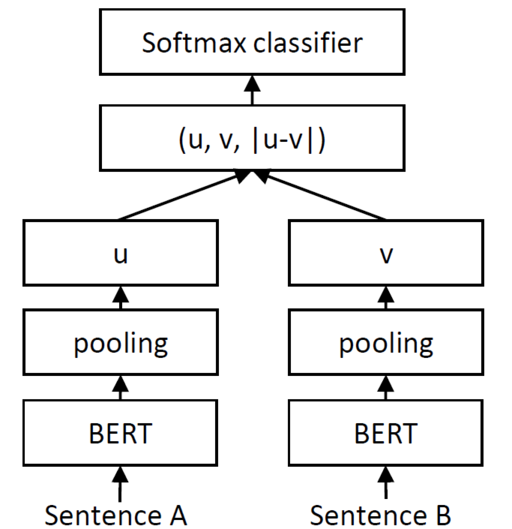

Tasks:

*   **[2 Point]** Prepare a training dataloader and training loop: Read in NLI data, tokenize and generate the corresponding data loader
*   **[2 Point]** BertClassifier: Construct a model that uses above method

**Download NLI dataset**

This dataset includes:
*   Sentence pairs: (sentence1, sentence2)
*   Label: (contradiction, entailment, neutral)
*   Split: train, dev, test

In [15]:
!wget 'https://sbert.net/datasets/AllNLI.tsv.gz'

--2023-10-01 04:14:21--  https://sbert.net/datasets/AllNLI.tsv.gz
Resolving sbert.net (sbert.net)... 104.21.67.200, 172.67.180.145, 2606:4700:3036::6815:43c8, ...
Connecting to sbert.net (sbert.net)|104.21.67.200|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://public.ukp.informatik.tu-darmstadt.de/reimers/sentence-transformers/datasets/AllNLI.tsv.gz [following]
--2023-10-01 04:14:21--  https://public.ukp.informatik.tu-darmstadt.de/reimers/sentence-transformers/datasets/AllNLI.tsv.gz
Resolving public.ukp.informatik.tu-darmstadt.de (public.ukp.informatik.tu-darmstadt.de)... 130.83.167.186
Connecting to public.ukp.informatik.tu-darmstadt.de (public.ukp.informatik.tu-darmstadt.de)|130.83.167.186|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 40794454 (39M) [application/octet-stream]
Saving to: ‘AllNLI.tsv.gz’

AllNLI.tsv.gz       100%[===================>]  38.90M  14.5MB/s    in 2.7s    

2023-10-01 04:14:25 (14

In [11]:
data = pd.read_csv('AllNLI.tsv.gz', nrows=5, compression='gzip', delimiter='\t')
data.head()

,split,dataset,filename,sentence1,sentence2,label
0,train,SNLI,snli_1.0_train,A person on a horse jumps over a broken down a...,A person is training his horse for a competition.,neutral
1,train,SNLI,snli_1.0_train,A person on a horse jumps over a broken down a...,"A person is at a diner, ordering an omelette.",contradiction
2,train,SNLI,snli_1.0_train,A person on a horse jumps over a broken down a...,"A person is outdoors, on a horse.",entailment
3,train,SNLI,snli_1.0_train,Children smiling and waving at camera,They are smiling at their parents,neutral
4,train,SNLI,snli_1.0_train,Children smiling and waving at camera,There are children present,entailment


### **Implementation explanation**

1. **load_nli_dataset()**: I have a very similar implementation to `load_sts_dataset()` using gzip and CSV DictReader python package. However, I'm converting textual labels to integers to simplify the output of model training and inference.

2. **train_loop()**: The train loop iterates over batches of tokenized sentence pairs and moves these examples to the specified device (cpu or gpu). PyTorch greatly simplifies backpropagation using gradient descent algorithm with just on line of code `loss.backward()`. PyTorch accumulates the gradients across the batches therefore it is important to reset the gradients to zero using `optimizer.zero_grad()`. At the end of the epoch, I calculate the average loss across the batches and print it for monitoring training progress. With every epoch the loss should decrease.

3. **BERTClassifier()**: The is a text classification model that uses the custom BERT implementation above to generate sentence embeddings and map it to one of the three classes in the NLI dataset. The embeddings are generated for a batch of sentence1's and sentence2's.

 Following the image of the shared encoder architecture above, I concatenate the embeddings of sentence 1 (u), sentence 2 (v), and there absolute difference (|u-v|). These concatenated embeddings are passed through a dropout layer followed by a linear layer that maps it from 384 dimensions (128*3) to the 3 classes in the NLI dataset. Categorical cross entropy loss is the most popular choice for classification models. We don't need to implement a Softmax layer as the `F.cross_entropy` function does that for us.

In [12]:
def load_nli_dataset(allnli_dataset_path, contrastive=False):
  # add code to load NLI dataset in required format
  label_map = {"contradiction": 0, "entailment": 1, "neutral": 2}
  train_samples = []
  dev_samples = []
  test_samples = []
  with gzip.open(allnli_dataset_path, 'rt', encoding='utf8') as fIn:
      reader = csv.DictReader(fIn, delimiter='\t', quoting=csv.QUOTE_NONE)
      for row in tqdm(reader):
          label = row['label']
          if contrastive and label == "neutral":
            continue
          if row['split'] == 'dev':
              dev_samples.append((row['sentence1'], row['sentence2'], label_map[label]))
          elif row['split'] == 'test':
              test_samples.append((row['sentence1'], row['sentence2'], label_map[label]))
          else:
              train_samples.append((row['sentence1'], row['sentence2'], label_map[label]))
  nli_samples = {
      "train": train_samples,
      "dev": dev_samples,
      "test": test_samples
  }
  return nli_samples


def train_loop(model, optimizer, train_dataloader, num_epochs, device):
  # add code to for training loop
  # use optimizer, train_dataloader, num_epoch and device for training
  # Move the model to the specified device
  model = model.to(device)

  # Training loop
  for epoch in range(num_epochs):
      model.train()  # Set the model to training mode
      total_loss = 0.0

      # Iterate over the examples in the batch
      for input_ids1, input_mask1, input_ids2, input_mask2, label in tqdm(train_dataloader):
          # Move batch data to the specified device
          sentence_features = [(input_ids1.to(device), input_mask1.to(device)), (input_ids2.to(device), input_mask2.to(device))]

          # Zero the gradients
          optimizer.zero_grad()

          # Forward pass
          loss = model(sentence_features, label.to(device))

          # Backward pass
          loss.backward()

          # Update model parameters
          optimizer.step()

          total_loss += loss.item()

      # Print average loss for the epoch
      avg_loss = total_loss / len(train_dataloader)
      print(f"Epoch {epoch + 1}/{num_epochs} - Average Loss: {avg_loss:.4f}")


class BertClassifier(nn.Module):
    # add __init__ to construct BERTClassifier based on given pretrained BERT
    # add code for forward pass that returns the loss value
    # add aditional method if required
    def __init__(self, weights_path, config_dict, num_labels=3):
        super(BertClassifier, self).__init__()
        self.config = Config.from_dict(config_dict)
        self.num_labels = num_labels
        self.bert = Bert(config_dict).load_model(weights_path)
        self.dropout = nn.Dropout(self.config.hidden_dropout_prob)
        self.classifier = nn.Linear(3*self.config.hidden_size, num_labels)

    def forward(self, sentence_features, labels=None):
        # Get sentence embeddings
        embeddings = []
        for input_feature in sentence_features:
          input_ids, input_mask = input_feature
          embeddings.append(self.bert(input_ids=input_ids, attention_mask=input_mask)[1])

        # Calculate the absolute difference of the embeddings
        embeddings.append(torch.abs(embeddings[0] - embeddings[1]))

        features = torch.cat(embeddings, dim=1)
        # Dropout is optional
        pooled_output = self.dropout(features)
        logits = self.classifier(pooled_output)

        if labels is not None:
            loss = F.cross_entropy(logits.view(-1, self.num_labels), labels.view(-1))
            return loss
        else:
            return logits

**Training**

In [13]:
#INFO: model and training configs
model_name = 'prajjwal1/bert-tiny'
num_epochs = 3
batch_size = 8
num_labels = 3
# hidden_size = 256
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
tokenizer = AutoTokenizer.from_pretrained(model_name)
bert_config = {"hidden_size": 128, "num_attention_heads": 2, "num_hidden_layers": 2, "intermediate_size": 512, "vocab_size": 30522}
bert_path = 'bert_tiny.bin'

#INFO: load nli dataset
nli_dataset = load_nli_dataset('AllNLI.tsv.gz')

#INFO: tokenize dataset
#WARNING: Use only first 50000 samples and maximum sequence length of 128
tokenized_train = tokenize_sentence_pair_dataset(nli_dataset['train'][:50000], tokenizer, max_length=128)

#INFO: generate train_dataloader
train_dataloader = get_dataloader(tokenized_train, batch_size=batch_size, shuffle=True)

# Create a BertClassifier with required parameters
###    Replace None with required input based on yor implementation
bert_classifier = BertClassifier(weights_path=bert_path, config_dict=bert_config, num_labels=num_labels)

#INFO: create optimizer and run training loop
optimizer = AdamW(bert_classifier.parameters(), lr=5e-5)
train_loop(bert_classifier, optimizer, train_dataloader, num_epochs, device)

0it [00:00, ?it/s]

  0%|          | 0/6250 [00:00<?, ?it/s]

Epoch 1/3 - Average Loss: 0.9267


  0%|          | 0/6250 [00:00<?, ?it/s]

Epoch 2/3 - Average Loss: 0.7873


  0%|          | 0/6250 [00:00<?, ?it/s]

Epoch 3/3 - Average Loss: 0.7240


**Evaluation**

Expected result:

Pearson correlation: 0.37

Spearman correlation: 0.42

In [14]:
# run evaluation loop
result_from_classification = eval_loop(bert_classifier.bert, test_dataloader, device)
print(f'\nPearson correlation: {result_from_classification[0]:.2f}\nSpearman correlation: {result_from_classification[1]:.2f}')

  0%|          | 0/1379 [00:00<?, ?it/s]


Pearson correlation: 0.49
Spearman correlation: 0.52


# **Coding Challenge Part 4: Learning sentence embedding using a contrastive approach based on NLI dataset [3 Points]**

**Please DO NOT use additional library except the ones that are imported!!**

In this part, you are asked to explore another method that leverages a contrastive approach using NLI dataset.

Tasks **[3 Points]** :

*   Generate a dataloader if this is required for your approach
*   Construct a BERT based model using a contrastive method

### **Implementation explanation**

The contrastive loss is commonly used in tasks like siamese networks for learning embeddings that place similar items close to each other in the embedding space while pushing dissimilar items apart.

**Contrastive Loss** = $(Y)\frac{1}{2}(D)^2 + (1-Y)\frac{1}{2}\{max(0, m - D)\}^2$

Where,
* y is the label indicating whether the pair is similar (y==1) or dissimilar (y==0).
* D is the the cosine distance between the two embeddings (Cosine distance = 1 - Cosine similarity).
* m is the margin, a hyperparameter that specifies how far apart dissimilar points should be in the embedding space.

The first term penalizes the distance between similar points and the second term penalizes the distance between dissimilar points if that distance is less than the margin. The half factors are included for mathematical convenience, making it easier to take derivatives.

Further information: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf

I use the same methodoloy as `BERTClassifier()` to get embeddings for a batch and calculate cosine distances. I then plug the distances and the labels in the contrastive loss formula to calculate the loss. Summing or averaging the loss values for a batch produces the same results.



In [15]:
class BertContrastive(nn.Module):
    # add __init__ to construct BertContrastive based on given pretrained BERT
    # add code for forward pass that returns the loss value
    # add aditional method if required
    def __init__(self, weights_path, config_dict):
        super(BertContrastive, self).__init__()
        self.config = Config.from_dict(config_dict)
        self.bert = Bert(config_dict).load_model(weights_path)
        # The cosine distance
        self.distance_metric = lambda x, y: 1-F.cosine_similarity(x, y)
        # Minimum distance between the positive and negative labels
        self.margin = 0.5

    def forward(self, sentence_features, labels=None):
        # Get sentence embeddings
        embeddings = []
        for input_feature in sentence_features:
          input_ids, input_mask = input_feature
          embeddings.append(self.bert(input_ids=input_ids, attention_mask=input_mask)[1])

        emb_anchor, emb_other = embeddings
        distances = self.distance_metric(emb_anchor, emb_other)
        if labels is not None:
          # Formula for contrastive loss
          loss = 0.5 * (labels.float() * distances.pow(2) + (1 - labels).float() * F.relu(self.margin - distances).pow(2))
          return loss.sum()
        else:
          return distances


**Training**

In [16]:
#INFO: model and training configs
model_name = 'prajjwal1/bert-tiny'
num_epochs = 3
batch_size = 8
# num_labels =3
# hidden_size = 128
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
tokenizer = AutoTokenizer.from_pretrained(model_name)
bert_config = {"hidden_size": 128, "num_attention_heads": 2, "num_hidden_layers": 2, "intermediate_size": 512, "vocab_size": 30522}
bert_path = 'bert_tiny.bin'

#WARNING: Change this code if you implemented a different nli loader for this part
nli_dataset = load_nli_dataset('AllNLI.tsv.gz', contrastive=True)

#INFO: tokenize dataset
#WARNING: Use only first 50000 samples and maximum sequence lenght of 128
tokenized_train = tokenize_sentence_pair_dataset(nli_dataset['train'][:50000], tokenizer, max_length=128)

#INFO: generate train_dataloader
train_dataloader = get_dataloader(tokenized_train, batch_size=batch_size)

# Create a BertContrastive with required parameters
###    Replace None with required input based on yor implementation
bert_contrastive = BertContrastive(weights_path=bert_path, config_dict=bert_config)

#INFO: create optimizer and run training loop
optimizer = AdamW(bert_contrastive.parameters(), lr=5e-5)
train_loop(bert_contrastive, optimizer, train_dataloader, num_epochs, device)

0it [00:00, ?it/s]

  0%|          | 0/6250 [00:00<?, ?it/s]

Epoch 1/3 - Average Loss: 0.1904


  0%|          | 0/6250 [00:00<?, ?it/s]

Epoch 2/3 - Average Loss: 0.1467


  0%|          | 0/6250 [00:00<?, ?it/s]

Epoch 3/3 - Average Loss: 0.1258


**Evaluation**

In [17]:
# run evaluation loop
result_from_contrastive = eval_loop(bert_contrastive.bert, test_dataloader, device)
print(f'\nPearson correlation: {result_from_contrastive[0]:.2f}\nSpearman correlation: {result_from_contrastive[1]:.2f}')

  0%|          | 0/1379 [00:00<?, ?it/s]


Pearson correlation: 0.56
Spearman correlation: 0.57


# **Coding Challenge Part 5: Comparison [1 Point]**

In the final part of the coding challenge, you are asked to compare the result of pretrained BERT, classification based BERT, and contrastive method based BERT.

These are the tasks **[1 Point]**:


*   Plot the result for each model
*   Explain the difference between methods and their impact on the result and comparison

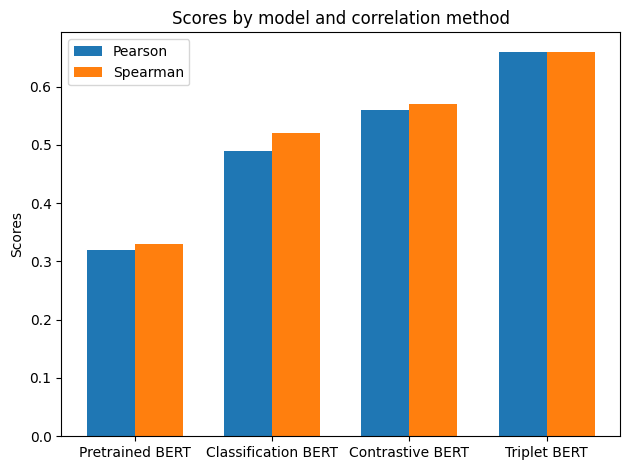

In [23]:
import matplotlib.pyplot as plt

# Triplet BERT is from the optional section below
pearson_scores = {'Pretrained BERT': 0.32, 'Classification BERT': 0.49, 'Contrastive BERT': 0.56, 'Triplet BERT': 0.66}
spearman_scores = {'Pretrained BERT': 0.33, 'Classification BERT': 0.52, 'Contrastive BERT': 0.57, 'Triplet BERT': 0.66}

labels = pearson_scores.keys()
# the label locations
x = np.arange(len(labels))
# the width of the bars
width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, pearson_scores.values(), width, label='Pearson')
rects2 = ax.bar(x + width/2, spearman_scores.values(), width, label='Spearman')

ax.set_ylabel('Scores')
ax.set_title('Scores by model and correlation method')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()

plt.show()

### **Explanation**

**NOTE**: Triplet BERT is from the optional section below.

The results show a consistent improvement in correlation scores as models are further fine-tuned on the NLI dataset with different loss functions. The performance improvement with Contrastive Loss and Multiple Negatives Ranking Loss (MNRL) over Cross Entropy Loss is likely due to their design for similarity learning tasks. Contrastive Loss minimizes the distance between similar pairs and maximizes it for dissimilar pairs, facilitating better similarity representations. MNRL, by considering multiple negative examples, offers a more robust learning of similarity relationships, thus yielding better performance. Contrastive loss and MNRL loss functions aligns better with the inherent nature of this task (measuring sentence similarity), making these loss functions more suited than Cross Entropy Loss, which is traditionally used for classification tasks.



# **[OPTIONAL] Explore an alternative way to improve sentence encoder in terms of *performance* or *efficiency* [6 Points]**

Potential directions:
*   <u>Improve the methodology to compute higher quality sentence embeddings</u> (My choice)  
*   Improve the efficiency during fine-tuning in terms of memory or training time
*   Use different machine learning methods that leverages other resources such as auxillary/teacher models
*   Use different datasets with other training objectives


**You can use any additional model, dataset, library or package for this part!!**

### **Improving sentence embeddings using Multiple Negatives Ranking Loss with hard negatives**

In this approach, I want to continue the momentum of using our custom Tiny BERT implementation with pre-trainined STS weights. Keeping all the hyperparameters (like the max length, batch size, and the number of samples used for training) the same, I just want to focus on improving the methodology of training (loss function) to compute higher quality sentence embeddings.

While increasing the number of datapoints, performing curriculum learning with multiple datasets, model distillation, or increasing the model size seems to be the obvious approach to improve embedding quality, they come with higher compute requirements. I want to preserve all the previous constraints for a fair comparison of the approach below.

**Background**

1. **Contrastive loss**: Operates on pairs: an anchor and a positive or negative example. It aims to minimize the distance between similar pairs and maximize the distance between dissimilar pairs.

2. **Triplet loss**: Operates on triplets: an anchor, a positive, and a negative example. It aims to ensure the anchor is closer to the positive than to the negative by a margin.

**Multiple Negatives Ranking Loss (MNLR)**

**TLDR**: MNLR extends the idea of Triplet loss by considering multiple negative examples instead of just one. In training, an anchor-positive pair is considered alongside several negatives, optimizing the model to produce similar embeddings for the anchor-positive pair while different embeddings for non-pairs.

The training data for MultipleNegativesRankingLoss consists of sentence pairs [(a1, b1), …, (an, bn)] where we assume that (ai, bi) are similar sentences and (ai, bj) are dissimilar sentences for i != j. This loss minimizes the distance between (ai, bi) while it simultaneously maximizes the distance (ai, bj) for all i != j.

We can further improve MultipleNegativesRankingLoss by not only providing pairs, but by providing triplets: [(a1, b1, c1), …, (an, bn, cn)]. The entry for ci are so-called hard-negatives. Using MultipleNegativeRankingLoss with NLI dataset is easy: We define sentences that have an entailment label as positive pairs and contradiction label as hard negatives. So our triplets look like this: (“A soccer game with multiple males playing.”, “Some men are playing a sport.”, “A group of men playing a baseball game.”).


Reference: https://www.sbert.net/examples/training/nli/README.html#multiplenegativesrankingloss


In [16]:
import random

**1. Load and pre-process NLI dataset**

I modify the train samples in `load_nli_dataset()` function to load all possible triplets. Every sentence is mapped to the list of entailments and contradictions that are present in the NLI dataset for this particular sentence. This approach might create duplicates which are handled in the `NoDuplicatesDataLoader()`.

Since I am using the same STS pre-trained Custom Tiny BERT model, I re-use the tokenizer to convert sentence to token ids and create corresponding input masks and pad both of them to the max sequence length.

In [17]:
def load_nli_dataset_triplets(allnli_dataset_path):
  # add code to load NLI dataset in required format
  label_map = {"contradiction": 0, "entailment": 1, "neutral": 2}
  train_data = {}
  dev_samples = []
  test_samples = []
  with gzip.open(allnli_dataset_path, 'rt', encoding='utf8') as fIn:
      reader = csv.DictReader(fIn, delimiter='\t', quoting=csv.QUOTE_NONE)
      for row in tqdm(reader):
          label = row['label']
          if row['split'] == 'dev':
              # Not being used
              dev_samples.append((row['sentence1'], row['sentence2'], label_map[label]))
          elif row['split'] == 'test':
              # Not being used
              test_samples.append((row['sentence1'], row['sentence2'], label_map[label]))
          else:
              # Updated for BertTriplet
              sent1 = row['sentence1']
              sent2 = row['sentence2']
              if sent1 not in train_data:
                  train_data[sent1] = {'contradiction': set(), 'entailment': set(), 'neutral': set()}
              train_data[sent1][label].add(sent2)
              # Also add the opposite
              if sent2 not in train_data:
                  train_data[sent2] = {'contradiction': set(), 'entailment': set(), 'neutral': set()}
              train_data[sent2][label].add(sent1)

  # Providing hard negatives per anchor-positive pair by structuring data like this: (a_1, p_1, n_1), (a_2, p_2, n_2)
  train_samples = []
  for sent1, others in train_data.items():
      if len(others['entailment']) > 0 and len(others['contradiction']) > 0:
          train_samples.append((sent1, random.choice(list(others['entailment'])), random.choice(list(others['contradiction']))))
          train_samples.append((random.choice(list(others['entailment'])), sent1, random.choice(list(others['contradiction']))))


  nli_samples = {
      "train": train_samples,
      "dev": dev_samples,
      "test": test_samples
  }
  return nli_samples

def convert_sentence_to_features(sentence, tokenizer, max_length=128):
  # Convert sentence to features
  tokens = tokenizer.tokenize(sentence)
  # Add the CLS and SEP token for fine-tuned bert model
  tokens = ["[CLS]"] + tokens + ["[SEP]"]
  input_ids = tokenizer.convert_tokens_to_ids(tokens)
  # The mask has 1 for real tokens and 0 for padding tokens
  input_mask = [1] * len(input_ids)
  # Zero-pad up to the sequence length
  padding = [0] * (max_length - len(input_ids))
  input_ids += padding
  input_mask += padding
  input_ids = torch.tensor(input_ids, dtype=torch.long)
  input_mask = torch.tensor(input_mask, dtype=torch.long)

  return input_ids, input_mask


def tokenize_triplet_dataset(train_samples, tokenizer, max_length=128):
  tokenized_train_samples = []
  for (anchor, positive, negative) in tqdm(train_samples):
    # Convert sentences to features
    anchor_ids, anchor_mask = convert_sentence_to_features(anchor, tokenizer, max_length=max_length)
    positive_ids, positive_mask = convert_sentence_to_features(positive, tokenizer, max_length=max_length)
    negative_ids, negative_mask = convert_sentence_to_features(negative, tokenizer, max_length=max_length)
    tokenized_train_samples.append([
        # Storing the text to identify duplicates in NoDuplicatesDataLoader()
        (anchor, positive, negative),
        # Storing input ids and mask for anchor, positive, and negative sentences
        (anchor_ids, anchor_mask),
        (positive_ids, positive_mask),
        (negative_ids, negative_mask)
    ])
  return tokenized_train_samples

**2. Define the similarity metric and the BertTriplet model**

**Cosine similarity**: I use a slightly modified version of the cosine similarity method here to take non-tensors as input and convert them if needed.

**BertTriplet**: The input to this model contains features for 3 sentences (anchor, positive, negative) for each example in a batch. Embeddings are calculated for all the three sentence types in a batched manner to make most of the GPUs. Assuming batch_size of 8, cosine similarities are calculated as 8 (anchors) x 16 (positives + negatives) matrix. Framing this as a classification problem (where the number of classes/labels is 16), the label for ith example in the batch should correspond to the ith index in the output. Rest all the labels are negatives as explained in MNRL above.

Therefore, labels are generated as a sequence of integers [0, ..., batch_size-1] for the batch, indicating the anchor should match the positive example corresponding to the same index. The cosine similarities are scaled and passed to the `nn.CrossEntropyLoss()` to compute the loss. This setup encourages the model to learn embeddings such that the cosine similarity with positive example is higher than with negative examples, thus ensuring similar examples have closer embeddings and dissimilar examples have distant embeddings.

In [18]:
def cos_sim(a, b):
    """
    Computes the cosine similarity cos_sim(a[i], b[j]) for all i and j
    """
    if not isinstance(a, torch.Tensor):
        a = torch.tensor(a)

    if not isinstance(b, torch.Tensor):
        b = torch.tensor(b)

    if len(a.shape) == 1:
        a = a.unsqueeze(0)

    if len(b.shape) == 1:
        b = b.unsqueeze(0)

    a_norm = F.normalize(a, p=2, dim=1)
    b_norm = F.normalize(b, p=2, dim=1)
    return torch.mm(a_norm, b_norm.transpose(0, 1))


class BertTriplet(nn.Module):
  def __init__(self, weights_path, config_dict):
        super(BertTriplet, self).__init__()
        self.config = Config.from_dict(config_dict)
        self.bert = Bert(config_dict).load_model(weights_path)
        self.scale = 20.0
        self.cross_entropy_loss = nn.CrossEntropyLoss()

  def forward(self, sentence_features, labels=None):
        # Get pooled output for all the batches
        embeddings = [self.bert(input_ids=input_ids, attention_mask=input_masks)[1] for (input_ids, input_masks) in sentence_features]

        embeddings_a = embeddings[0]
        embeddings_b = torch.cat(embeddings[1:])

        scores = cos_sim(embeddings_a, embeddings_b) * self.scale
        # Example a[i] should match with b[i]
        labels = torch.tensor(range(len(scores)), dtype=torch.long, device=scores.device)
        # Minimize the negative log-likehood for softmax normalized scores
        batch_loss = self.cross_entropy_loss(scores, labels)
        return batch_loss

**3. Define the DataLoader and the training loop**

**NoDuplicatesDataLoader**: A special data loader to be used with MultipleNegativesRankingLoss. This data loader ensures that there are no duplicate sentences within the same batch.

**Train loop**: The training loop is similar to the one above. The only difference is the flatten out the three sentences: anchor, positive, and negative from each example in the train dataloader. This helps run inference on the complete batch of input instead of individual sentences in each example which is very slow.



In [19]:
class NoDuplicatesDataLoader:
    """DataLoader that removes duplicate texts from a batch"""
    def __init__(self, train_examples, batch_size):
        self.batch_size = batch_size
        self.data_pointer = 0
        self.train_examples = train_examples
        random.shuffle(self.train_examples)

    def __iter__(self):
        for _ in range(self.__len__()):
            batch = []
            texts_in_batch = set()

            # Loop until the batch is full
            while len(batch) < self.batch_size:
                example = self.train_examples[self.data_pointer]

                # Assume the example is valid
                valid_example = True
                for text in example[0]:
                    # If the sentence is already present in the batch then skip
                    if text.strip().lower() in texts_in_batch:
                        valid_example = False
                        break
                # If the example is valid, append the input ids and mask
                if valid_example:
                    batch.append(example[1:])
                    # Save text to check against next example
                    for text in example[0]:
                        texts_in_batch.add(text.strip().lower())

                self.data_pointer += 1
                # Reset the pointer to start if it reaches the end of the training set
                if self.data_pointer >= len(self.train_examples):
                    self.data_pointer = 0
                    random.shuffle(self.train_examples)

            yield batch

    def __len__(self):
        # Calculates the number of examples in the data loader
        return math.floor(len(self.train_examples) / self.batch_size)


def triplet_train_loop(model, optimizer, train_dataloader, num_epochs, device):
  # add code to for training loop
  # use optimizer, train_dataloader, num_epoch and device for training
  # Move the model to the specified device
  model = model.to(device)

  # Training loop
  for epoch in range(num_epochs):
      model.train()  # Set the model to training mode
      total_loss = 0.0

      for batch_examples in tqdm(train_dataloader):

          # Zero the gradients
          optimizer.zero_grad()

          # Initialize lists to hold ids and masks for all examples in the batch
          sentence_features = [
              [[], []], # anchor features
              [[], []], # positive features
              [[], []]  # negative features
          ]
          # Populate the lists with ids and masks from each example
          for example in batch_examples:
              for idx, (ids, mask) in enumerate(example):
                  sentence_features[idx][0].append(ids)
                  sentence_features[idx][1].append(mask)

          # Stack the lists to form a batch tensor
          sentence_features = [
              [torch.stack(item) for item in feature] for feature in sentence_features
          ]
          sentence_features = [torch.stack(feature) for feature in sentence_features]
          sentence_features = torch.stack(sentence_features).to(device)

          # Call the model inference only once for the entire batch
          loss = model(sentence_features)

          # Backward pass
          loss.backward()

          # Update model parameters
          optimizer.step()

          total_loss += loss.item()

      # Print average loss for the epoch
      avg_loss = total_loss / len(train_dataloader)
      print(f"Epoch {epoch + 1}/{num_epochs} - Average Loss: {avg_loss:.4f}")

**4. Initialize the model, its config, and load the dataset**

In [20]:
#INFO: model and training configs
model_name = 'prajjwal1/bert-tiny'
num_epochs = 3
batch_size = 8
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
tokenizer = AutoTokenizer.from_pretrained(model_name)
bert_config = {"hidden_size": 128, "num_attention_heads": 2, "num_hidden_layers": 2, "intermediate_size": 512, "vocab_size": 30522}
bert_path = 'bert_tiny.bin'

#WARNING: Change this code if you implemented a different nli loader for this part
nli_dataset = load_nli_dataset_triplets('AllNLI.tsv.gz')

#INFO: tokenize dataset
#WARNING: Use only first 50000 samples and maximum sequence lenght of 128
tokenized_train = tokenize_triplet_dataset(nli_dataset['train'][:50000], tokenizer, max_length=128)

0it [00:00, ?it/s]

  0%|          | 0/50000 [00:00<?, ?it/s]

**5. Train the BertTriplet model using the Multiple Negatives Ranking Loss**

In [21]:
#INFO: generate train_dataloader
train_dataloader = NoDuplicatesDataLoader(tokenized_train, batch_size=batch_size)

# Create a BertTriplet with required parameters
###    Replace None with required input based on yor implementation
bert_triplet = BertTriplet(weights_path=bert_path, config_dict=bert_config)

#INFO: create optimizer and run training loop
optimizer = AdamW(bert_triplet.parameters(), lr=5e-5)
triplet_train_loop(bert_triplet, optimizer, train_dataloader, num_epochs, device)

  0%|          | 0/6250 [00:00<?, ?it/s]

Epoch 1/3 - Average Loss: 0.9559


  0%|          | 0/6250 [00:00<?, ?it/s]

Epoch 2/3 - Average Loss: 0.5882


  0%|          | 0/6250 [00:00<?, ?it/s]

Epoch 3/3 - Average Loss: 0.4549


**6. Evaluate the embeddings on the STS test dataset**

In [22]:
# run evaluation loop
result_from_triplet = eval_loop(bert_triplet.bert, test_dataloader, device)
print(f'\nPearson correlation: {result_from_triplet[0]:.2f}\nSpearman correlation: {result_from_triplet[1]:.2f}')

  0%|          | 0/1379 [00:00<?, ?it/s]


Pearson correlation: 0.66
Spearman correlation: 0.66


**Conclusion**: Classification using Softmax-loss with NLI data produces (relatively) good sentence embeddings is rather coincidental. The MultipleNegativesRankingLoss is much more intuitive and produces significantly better sentence representations.

**NOTE**: In my submission Email, I stated the scores as 0.60 and 0.61. I apologize for that. There was a small bug in creating batches in the forward pass for the BertTriplet model that gave me those scores. After fixing the bug, I'm getting the new Pearson and Spearman scores as 0.66.